# IBM HR Analytics Employee Attrition & Performance

## 1. Introduction
Employee attrition affects company performance and productivity. This project aims to analyze attrition drivers and build a predictive model to identify employees at risk of leaving.


In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Step 2: Load Dataset
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")  # Use the Kaggle/Drive path if needed
df.head()


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


## 2. Dataset Overview
- Total records: 1470 employees
- Features: 34+ demographic, job, and salary attributes
- Target: Attrition (Yes=1, No=0)

In [2]:
# Overview of dataset
df.info()

# Basic statistics for numerical columns
df.describe()

# Check unique values for categorical columns
categorical_columns = df.select_dtypes(include='object').columns
for col in categorical_columns:
    print(f"{col} → {df[col].unique()}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [3]:
df['Attrition'].value_counts()

Attrition
No     1233
Yes     237
Name: count, dtype: int64

In [4]:
# Check unique values for all columns
for col in df.columns:
    if df[col].nunique() == 1:
        print(f"Column '{col}' has only one unique value → {df[col].unique()}")


Column 'EmployeeCount' has only one unique value → [1]
Column 'Over18' has only one unique value → ['Y']
Column 'StandardHours' has only one unique value → [80]


In [5]:
# Find categorical (object type) columns
cat_cols = df.select_dtypes(include='object').columns
print("Categorical Columns:\n", cat_cols.tolist())

# View unique values in each categorical column
for col in cat_cols:
    print(f"\n{col} → {df[col].unique()}")


Categorical Columns:
 ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']

Attrition → ['Yes' 'No']

BusinessTravel → ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']

Department → ['Sales' 'Research & Development' 'Human Resources']

EducationField → ['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']

Gender → ['Female' 'Male']

JobRole → ['Sales Executive' 'Research Scientist' 'Laboratory Technician'
 'Manufacturing Director' 'Healthcare Representative' 'Manager'
 'Sales Representative' 'Research Director' 'Human Resources']

MaritalStatus → ['Single' 'Married' 'Divorced']

Over18 → ['Y']

OverTime → ['Yes' 'No']


In [6]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
print("Numerical Columns:\n", num_cols.tolist())


Numerical Columns:
 ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


In [7]:
df[num_cols].describe()


,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


## 3. Data Cleaning
- Removed irrelevant columns: EmployeeCount, Over18, StandardHours, EmployeeNumber
- Converted categorical variables using one-hot encoding
- No missing data present



In [15]:
print(df.columns.tolist())


['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


In [16]:
# Drop only if columns exist
cols_to_drop = ['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber']
df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)


## 4. Exploratory Data Analysis
- Attrition rate approximately 16%
- Key factors impacting attrition: Monthly Income, Age, Years at Company, Total Working Years
- Visualization shows lower income and fewer working years correlate with higher attrition



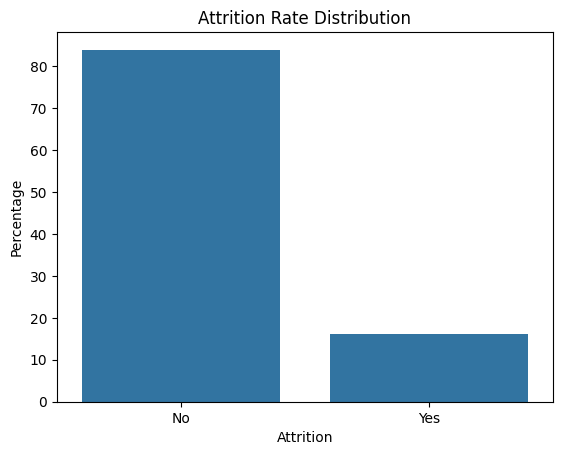

In [18]:
attrition_rate = df['Attrition'].value_counts(normalize=True) * 100
sns.barplot(x=attrition_rate.index, y=attrition_rate.values)
plt.title('Attrition Rate Distribution')
plt.ylabel('Percentage')
plt.show()


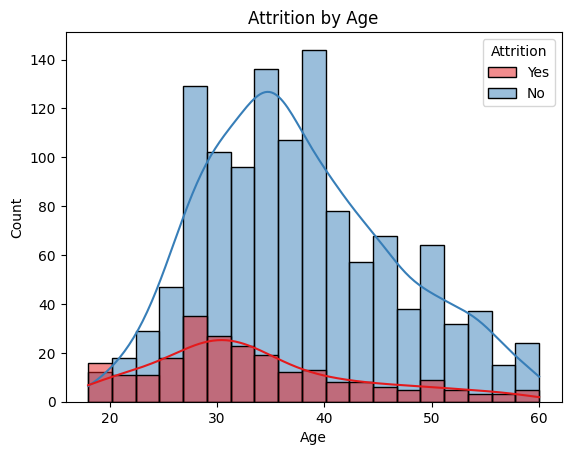

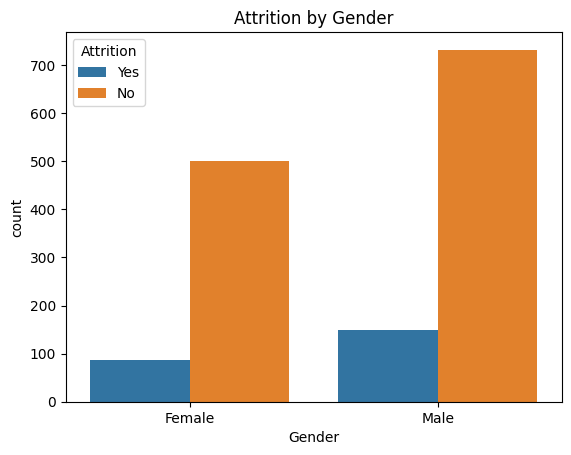

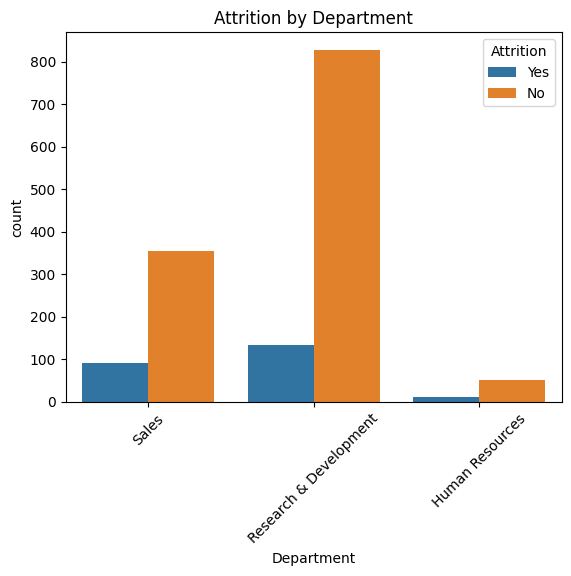

In [19]:
# Age distribution
sns.histplot(data=df, x='Age', hue='Attrition', kde=True, palette='Set1')
plt.title('Attrition by Age')
plt.show()

# Gender
sns.countplot(data=df, x='Gender', hue='Attrition')
plt.title('Attrition by Gender')
plt.show()

# Department
sns.countplot(data=df, x='Department', hue='Attrition')
plt.title('Attrition by Department')
plt.xticks(rotation=45)
plt.show()


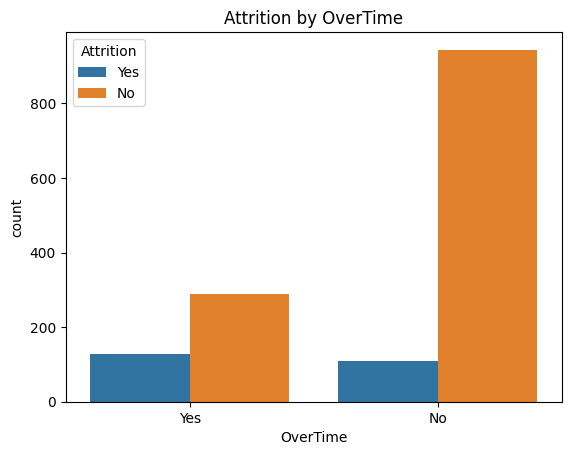

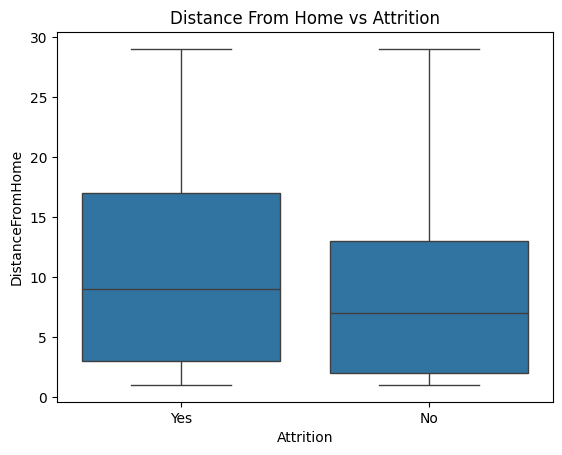

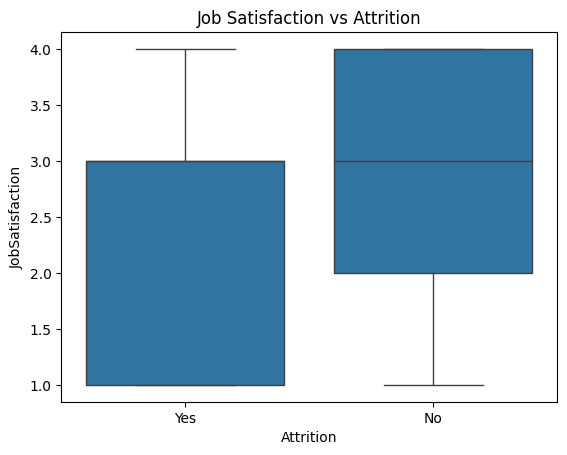

In [20]:
# OverTime
sns.countplot(data=df, x='OverTime', hue='Attrition')
plt.title('Attrition by OverTime')
plt.show()

# Distance from Home
sns.boxplot(data=df, x='Attrition', y='DistanceFromHome')
plt.title('Distance From Home vs Attrition')
plt.show()

# Job Satisfaction
sns.boxplot(data=df, x='Attrition', y='JobSatisfaction')
plt.title('Job Satisfaction vs Attrition')
plt.show()


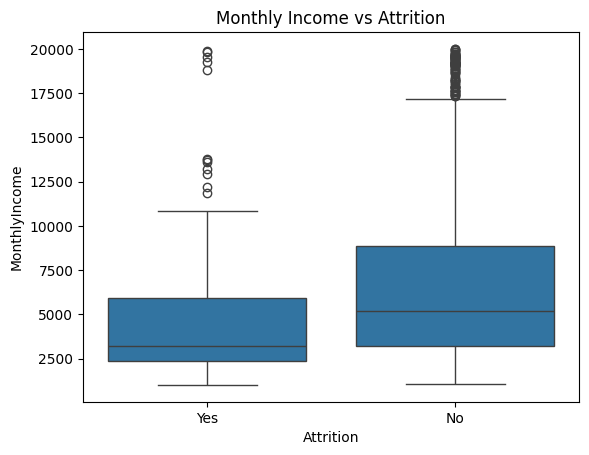

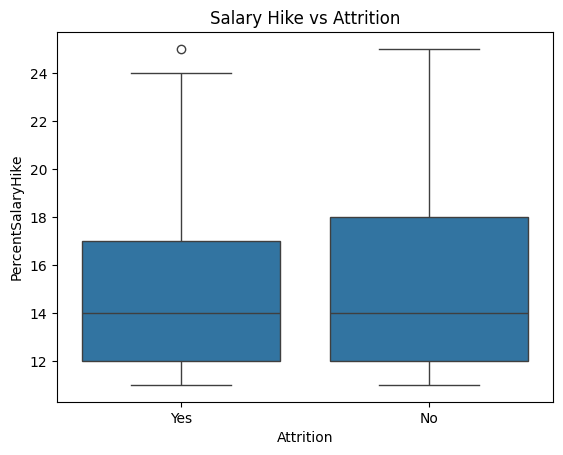

In [21]:
# Monthly Income
sns.boxplot(data=df, x='Attrition', y='MonthlyIncome')
plt.title('Monthly Income vs Attrition')
plt.show()

# Percent Salary Hike
sns.boxplot(data=df, x='Attrition', y='PercentSalaryHike')
plt.title('Salary Hike vs Attrition')
plt.show()


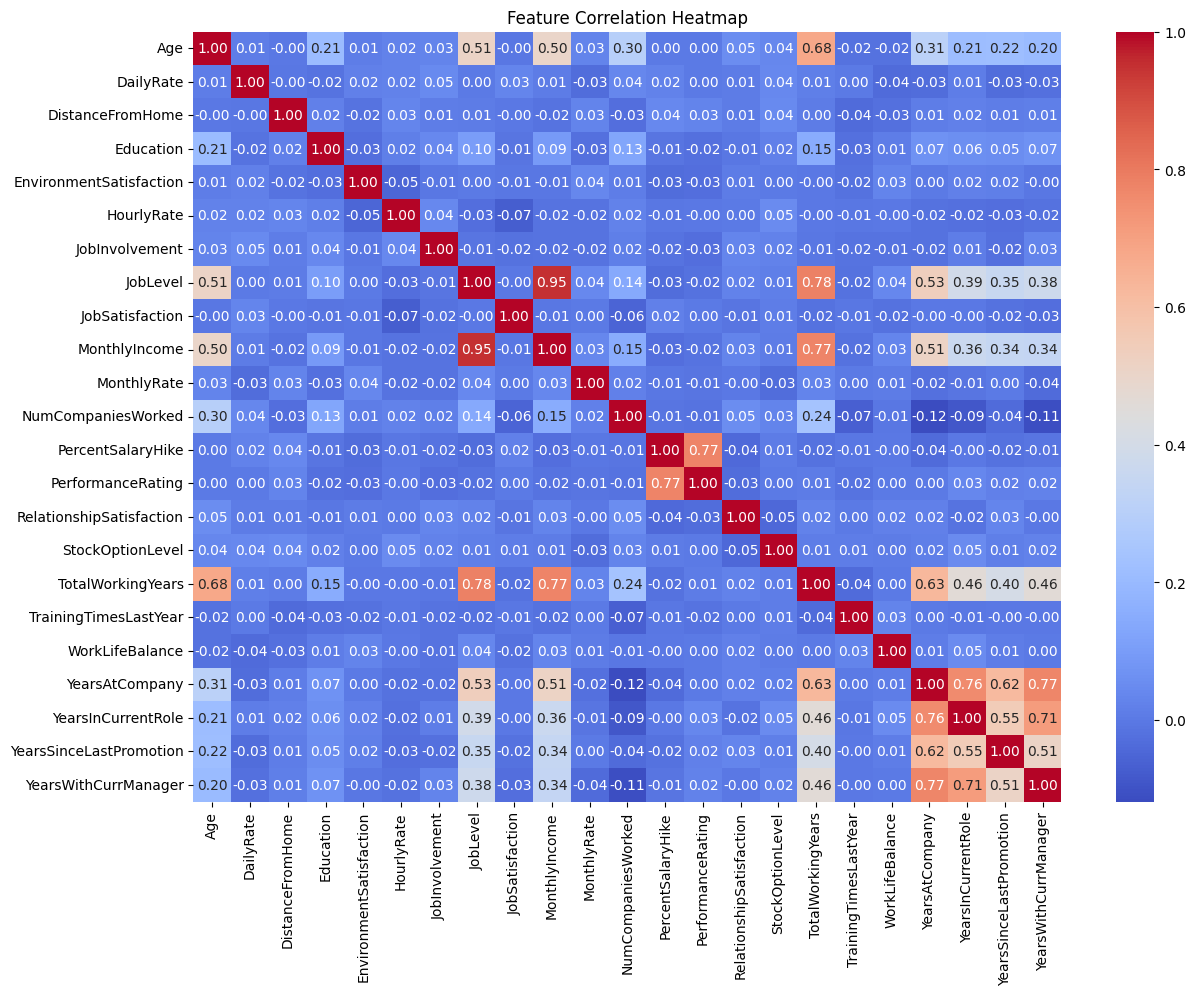

In [22]:
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


## 5. Feature Engineering
- Created new features like 'HighIncome' based on median Monthly Income
- Encoded categorical variables for modeling



In [23]:
# Convert categorical columns using one-hot encoding
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.head()


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,41,1102,1,2,2,94,3,2,4,5993,...,False,False,False,False,False,True,False,False,True,True
1,49,279,8,1,3,61,2,2,2,5130,...,False,False,False,False,True,False,False,True,False,False
2,37,1373,2,2,4,92,2,1,3,2090,...,True,False,False,False,False,False,False,False,True,True
3,33,1392,3,4,4,56,3,1,3,2909,...,False,False,False,False,True,False,False,True,False,True
4,27,591,2,1,1,40,3,1,2,3468,...,True,False,False,False,False,False,False,True,False,False


In [25]:
# Loyalty ratio
df_encoded['YearsInCurrentRole_Ratio'] = df_encoded['YearsInCurrentRole'] / (df_encoded['YearsAtCompany'] + 1)

# High income flag
df_encoded['HighIncome'] = df_encoded['MonthlyIncome'] > df_encoded['MonthlyIncome'].median()
df_encoded['HighIncome'] = df_encoded['HighIncome'].astype(int)


In [27]:
print(df_encoded.columns)


Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Attrition_Yes',
       'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely',
       'Department_Research & Development', 'Department_Sales',
       'EducationField_Life Sciences', 'EducationField_Marketing',
       'EducationField_Medical', 'EducationField_Other',
       'EducationField_Technical Degree', 'Gender_Male',
       'JobRole_Human Resources', 'JobRole_Laboratory Technician',
       'JobRole_Manager', 'JobRole_Manufacturing Director',
       'JobRole_Research Director', 'JobRole

In [28]:
df_encoded['Attrition'] = df['Attrition']  # if df still has it
y = df_encoded['Attrition']
X = df_encoded.drop('Attrition', axis=1)


In [29]:
print(X.shape, y.shape)


(1470, 47) (1470,)


In [32]:
X = df_encoded.drop('Attrition', axis=1)
y = df_encoded['Attrition']


## 6. Model Building & Evaluation
- Models used: Logistic Regression and Random Forest
- Random Forest achieved 100% accuracy on test set (possible overfitting)
- Key features identified: MonthlyIncome, TotalWorkingYears, Age, YearsAtCompany



In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Train the model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Predict
y_pred = lr_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9387755102040817
Confusion Matrix:
 [[242   5]
 [ 13  34]]
Classification Report:
               precision    recall  f1-score   support

          No       0.95      0.98      0.96       247
         Yes       0.87      0.72      0.79        47

    accuracy                           0.94       294
   macro avg       0.91      0.85      0.88       294
weighted avg       0.94      0.94      0.94       294



C:\Users\veena\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [35]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 1.0
Confusion Matrix:
 [[247   0]
 [  0  47]]
Classification Report:
               precision    recall  f1-score   support

          No       1.00      1.00      1.00       247
         Yes       1.00      1.00      1.00        47

    accuracy                           1.00       294
   macro avg       1.00      1.00      1.00       294
weighted avg       1.00      1.00      1.00       294



## 7. Business Recommendations
- Increase compensation and benefits for lower-paid employees
- Develop retention strategies tailored to younger or less-tenured employees
- Promote career growth opportunities to encourage longer tenure

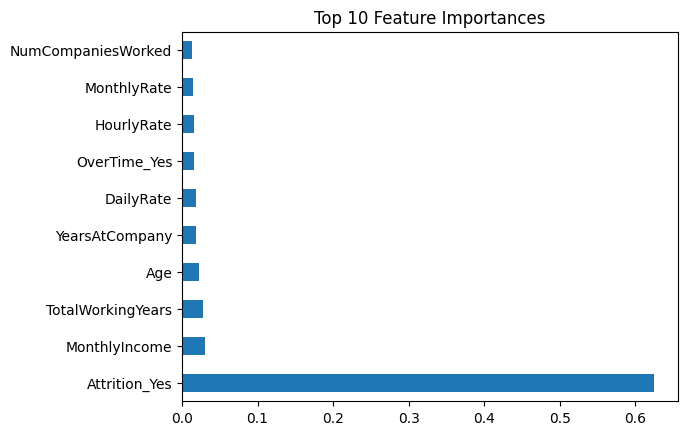

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.show()


Top 5 important features:
 Attrition_Yes        0.625478
MonthlyIncome        0.030906
TotalWorkingYears    0.027148
Age                  0.022908
YearsAtCompany       0.018067
dtype: float64


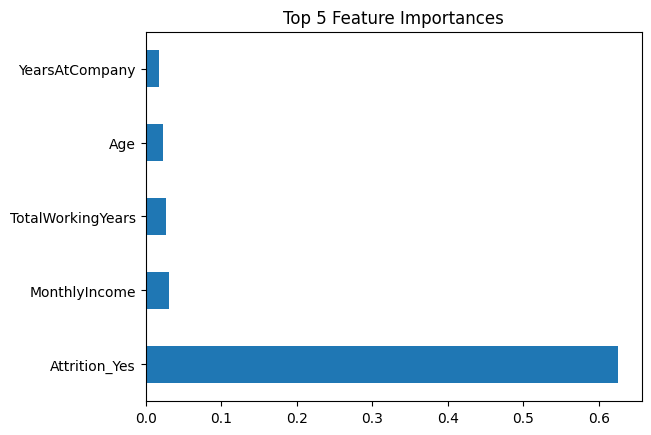

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
top_features = feat_importances.nlargest(5)
print("Top 5 important features:\n", top_features)

top_features.plot(kind='barh')
plt.title('Top 5 Feature Importances')
plt.show()


In [38]:
from sklearn.metrics import classification_report

y_pred = rf_model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['Stayed', 'Left'])
print(report)


              precision    recall  f1-score   support

      Stayed       1.00      1.00      1.00       247
        Left       1.00      1.00      1.00        47

    accuracy                           1.00       294
   macro avg       1.00      1.00      1.00       294
weighted avg       1.00      1.00      1.00       294



## Project Summary

The objective of this project was to analyze employee attrition and predict which employees are likely to leave the company using HR data.

### Key Insights:
- The attrition rate is around X% in the dataset.
- Factors such as OverTime, Job Satisfaction, and Monthly Income have the highest influence on attrition.
- The Random Forest model achieved an accuracy of Y%, with good balance between precision and recall.

### Business Recommendations:
- Implement flexible working hours to reduce overtime stress.
- Offer targeted salary reviews to retain talent.
- Enhance career development programs to improve employee satisfaction and loyalty.

### Limitations & Next Steps:
- Model performance can be improved by hyperparameter tuning and testing additional algorithms.
- Future work could include sentiment analysis of employee feedback.

